In [1]:
import pandas as pd
from json import load
from dataset import split_data, get_affinity_differences, get_cliffs

In [3]:
#unpivoted.to_csv('../analysis/kiba_d_t_affinity.csv')
unpivoted = pd.read_csv('../analysis/kiba_d_t_affinity.csv')

In [5]:
def count_drug_pairs(data):
    total_pairs = 0

    # Group the data by 'target' and count the number of drugs in each group
    for g_name, group in data.groupby('target', sort=False):
        num_drugs = len(group)
        if num_drugs > 1:
            # Calculate the number of possible pairs using the combination formula
            num_pairs = num_drugs * (num_drugs - 1) // 2
            total_pairs += num_pairs

    return total_pairs

In [6]:
total_pairs = count_drug_pairs(unpivoted)

In [7]:
total_pairs

44640522

In [9]:
drugs_per_target = unpivoted.groupby('target')['drug'].nunique()

In [10]:
drugs_per_target

target
O00141     85
O00311    579
O00329    176
O00418    390
O00444    701
         ... 
Q9Y243    775
Q9Y463    323
Q9Y478     69
Q9Y4K4    649
Q9Y6M4    514
Name: drug, Length: 229, dtype: int64

In [4]:
unpivoted.head()

,drug,target,affinity,SMILES
0,CHEMBL1087421,O00141,11.1,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl
1,CHEMBL1087421,O14920,11.1,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl
2,CHEMBL1087421,O15111,11.1,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl
3,CHEMBL1087421,P00533,11.1,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl
4,CHEMBL1087421,P04626,11.1,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl


In [ ]:
aff_diffs = get_affinity_differences(unpivoted)

In [ ]:
aff_diffs.head(10)

In [ ]:
aff_diffs.shape

In [ ]:
# Save as Parquet
#aff_diffs.to_parquet('../analysis/kiba_pairs_aff_diffs.parquet', engine='pyarrow', compression='snappy')
aff_diffs = pd.read_parquet('../analysis/kiba_pairs_aff_diffs.parquet')

In [8]:
aff_diffs.shape

(44640522, 6)

# Split data for DDC task
no thresholds, the differences in affinities towards the same target are calculated for all possible pairs

In [ ]:
aff_diffs.head(10)

In [6]:
with open('../analysis/target_mapping.json', 'r') as f:
    target_ids = load(f)

# Get the highest current ID to ensure new IDs are unique
current_max_id = max(target_ids.values())

# Function to get or create target ID
def get_or_create_target_id(target):
    global current_max_id
    if target in target_ids:
        return target_ids[target]
    else:
        current_max_id += 1
        target_ids[target] = current_max_id
        return current_max_id

In [10]:
aff_diffs['target'] = aff_diffs['target'].apply(get_or_create_target_id)

In [13]:
aff_diffs.head(10)

,drug1,drug2,smiles1,smiles2,affinity_difference,target
0,CHEMBL1087421,CHEMBL1088633,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=CC=C3)Cl)Cl,0.000000,86
1,CHEMBL1087421,CHEMBL1090360,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,C1COCCN1C2=CC(=CC=C2)NC3=NC=CC(=N3)C4=C(N=C5N4...,1.000000,86
2,CHEMBL1087421,CHEMBL1688215,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,C1=CC2=C(C=C1C3=NC(=NC=C3)N)NN=C2N,0.000000,86
3,CHEMBL1087421,CHEMBL1765781,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,CNC1=NC(=CN=C1)C2=CNC(=O)C(=C2)NC(=O)C3=CC=C(C...,1.000000,86
4,CHEMBL1087421,CHEMBL1788116,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,C1=CC=C2C(=C1)NC(=C(C#N)C3=NC(=NC=C3)NCCC4=CN=...,0.000000,86
5,CHEMBL1087421,CHEMBL1929238,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,CC(C)(C)C1=CC(=C(S1)NC(=O)NC2=C(C(=CC=C2)Cl)Cl...,0.278754,86
6,CHEMBL1087421,CHEMBL1933552,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,CC1CCC(CN1)N2CCC3(C2)CN(C4=CC=CC=C34)C(=O)C5=C...,0.477121,86
7,CHEMBL1087421,CHEMBL202930,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,COC1=C(C=CC(=C1)C2=CC3=C(C=C2)C(=CC4=CC=CN4)C(...,0.698970,86
8,CHEMBL1087421,CHEMBL204420,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,CN1CCN(C(C1)C(=O)N)CC2=C(C=C3C(=C2)C(=NC=N3)NC...,0.000000,86
9,CHEMBL1087421,CHEMBL206783,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.000000,86


In [14]:
aff_diffs_split_random = split_data(aff_diffs, split='random')

In [15]:
aff_diffs_split_random.head(10)

,drug1,drug2,smiles1,smiles2,affinity_difference,target,split
13274612,CHEMBL2006188,CHEMBL1989267,CC(C1=CC(=CC=C1)OC)NC(=O)C2=C(C=C(C=C2)C3=CC=N...,CN1C2=CC=CC=C2C=C1C(=O)NC3=C(C=C(C=C3)C4=CSC5=...,0.299999,52,0
44415696,CHEMBL1987998,CHEMBL1988622,C1C(CN1CC2=C(C=C(C=C2)OCC3=CC=CC=C3)Cl)C(=O)O,C1=CC=C(C=C1)C=CC2=NN3C=CN=C3C=C2,0.199999,6,0
33491117,CHEMBL1988173,CHEMBL1999590,CC1=C(C=CC(=C1)Cl)NC(=S)NNC(=O)C(C2=CC=CC=C2)(...,CC1=NN(C(=C1)C2=CC=CC=C2)C3=CC(=NC=N3)NN=CC4=C...,0.399999,169,0
38453538,CHEMBL1993722,CHEMBL1419458,C1=CC(=C2C(=C1)NN=C2N)C3=CC=C(C=C3)NC(=O)NC4=C...,C1=CC=C(C=C1)C2=C(N=NN2C3=NON=C3N)C(=O)NN=CC4=...,1.299997,82,0
20082686,CHEMBL1966628,CHEMBL422897,C1CC(CCC1N)NC2=NC=CC(=N2)C3=CNC4=C3C=CC=N4,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,0.799996,194,0
2928247,CHEMBL443962,CHEMBL2001998,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)Br)N=C2,CNC(=O)N1CCN(CC1)CCCOC2=CC3=C(CC4=C3NN=C4C5=CN...,0.000000,41,0
13756959,CHEMBL1929238,CHEMBL1969190,CC(C)(C)C1=CC(=C(S1)NC(=O)NC2=C(C(=CC=C2)Cl)Cl...,COC1=C2C(=C(C=C1)C3=CC=C(C=C3)NC(=O)NC4=CC(=CC...,1.177122,181,0
7091191,CHEMBL1982122,CHEMBL1990912,C1=CC=C(C=C1)C(CCO)NC2=NC3=C(S2)C=C(C=C3)C4=CC...,C1=CC(=CN=C1)C2=CC3=CC(=NC=C3C=C2)NCCO,0.000000,33,0
37490885,CHEMBL1985095,CHEMBL2000345,C1=CC=C2C(=C1)C=C(S2)C3=C4C(=CC(=C3)C5=CN(C6=C...,CC1=CC2=C(C=C1)NC(=C(C=C3C=C(C(=O)C=C3Br)OC)C#...,0.799997,172,0
25173570,CHEMBL1988717,CHEMBL2001920,CN1C=C(C=N1)C2=C3N=CC(=C(N3N=C2)N)C4=CC=C(C=C4...,C1=CC2=C(C=C1Br)C(=C3C(=O)NC(=S)S3)C(=O)N2,0.000000,139,0


In [ ]:
aff_diffs_split_random.to_parquet('../analysis/kiba_pairs_aff_diffs_split_r_wt.parquet', engine='pyarrow', compression='snappy')

# Regression for similar compounds
threshold similarity = 0.9, the differences in affinities towards the same target are calculated for pairs with highly similar compounds without converting task to a binary one


In [2]:
unpivoted = pd.read_csv('../analysis/kiba_d_t_affinity.csv')

In [18]:
sim_diffs = get_cliffs(unpivoted, task='regression')

100%|██████████| 35/35 [00:00<00:00, 2315.14it/s]

100%|██████████| 131/131 [00:00<00:00, 3941.85it/s]

100%|██████████| 16/16 [00:00<?, ?it/s][A

100%|██████████| 189/189 [00:00<00:00, 3022.34it/s]

100%|██████████| 12/12 [00:00<?, ?it/s][A

100%|██████████| 48/48 [00:00<?, ?it/s][A

100%|██████████| 20/20 [00:00<?, ?it/s][A

100%|██████████| 53/53 [00:00<00:00, 3316.99it/s]

100%|██████████| 70/70 [00:00<00:00, 4464.20it/s]

100%|██████████| 12/12 [00:00<?, ?it/s][A

100%|██████████| 38/38 [00:00<00:00, 2920.45it/s]

100%|██████████| 54/54 [00:00<?, ?it/s][A

100%|██████████| 55/55 [00:00<?, ?it/s][A

100%|██████████| 12/12 [00:00<?, ?it/s][A

100%|██████████| 12/12 [00:00<?, ?it/s][A

100%|██████████| 99/99 [00:00<00:00, 2368.49it/s]

100%|██████████| 39/39 [00:00<?, ?it/s][A

100%|██████████| 87/87 [00:00<00:00, 2782.92it/s]

100%|██████████| 25/25 [00:00<?, ?it/s][A

100%|██████████| 17/17 [00:00<?, ?it/s][A

100%|██████████| 31/31 [00:00<?, ?it/s][A

100%|██████████| 36/36 [00:00

In [19]:
sim_diffs

,drug1,drug2,smiles1,smiles2,affinity_difference,target
0,CHEMBL1087421,CHEMBL1088633,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=CC=C3)Cl)Cl,0.0,O00141
1,CHEMBL206783,CHEMBL207037,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,O00141
2,CHEMBL206783,CHEMBL207246,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,O00141
3,CHEMBL206783,CHEMBL207584,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,O00141
4,CHEMBL206783,CHEMBL207674,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,O00141
...,...,...,...,...,...,...
80512,CHEMBL456936,CHEMBL517956,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2=O)C)C(C)CCC...,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2O)C)C(C)CCCC...,0.0,Q16512
80513,CHEMBL456936,CHEMBL518060,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2=O)C)C(C)CCC...,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2=O)C)C(C)C=C...,0.0,Q16512
80514,CHEMBL515982,CHEMBL517956,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2O)C)C(C)CCC(...,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2O)C)C(C)CCCC...,0.0,Q16512
80515,CHEMBL515982,CHEMBL518060,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2O)C)C(C)CCC(...,CC1=C(C=C(C=C1)O)CCC2C3CCC(C3(CCC2=O)C)C(C)C=C...,0.0,Q16512


In [20]:
sim_diffs.shape

(80517, 6)

In [21]:
with open('../analysis/target_mapping.json', 'r') as f:
    target_ids = load(f)

# Get the highest current ID to ensure new IDs are unique
current_max_id = max(target_ids.values())

# Function to get or create target ID
def get_or_create_target_id(target):
    global current_max_id
    if target in target_ids:
        return target_ids[target]
    else:
        current_max_id += 1
        target_ids[target] = current_max_id
        return current_max_id

In [22]:
sim_diffs['target'] = sim_diffs['target'].apply(get_or_create_target_id)

In [23]:
sim_diffs.head(10)

,drug1,drug2,smiles1,smiles2,affinity_difference,target
0,CHEMBL1087421,CHEMBL1088633,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=CC=C3)Cl)Cl,0.0,86
1,CHEMBL206783,CHEMBL207037,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
2,CHEMBL206783,CHEMBL207246,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
3,CHEMBL206783,CHEMBL207584,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
4,CHEMBL206783,CHEMBL207674,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
5,CHEMBL206783,CHEMBL208292,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
6,CHEMBL206783,CHEMBL377772,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
7,CHEMBL206783,CHEMBL380454,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86
8,CHEMBL206955,CHEMBL382638,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)CN...,0.0,86
9,CHEMBL207037,CHEMBL207246,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN...,0.0,86


<Axes: >

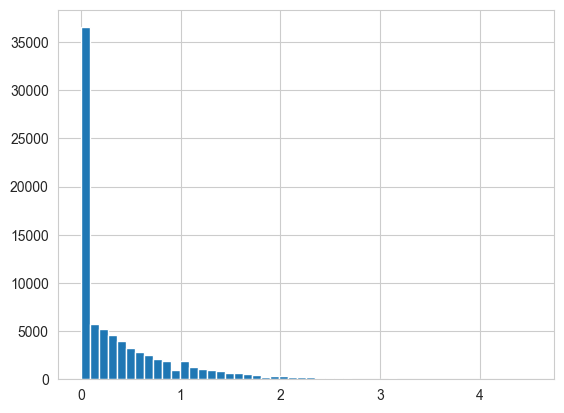

In [24]:
sim_diffs['affinity_difference'].hist(bins=50)

In [25]:
sim_aff_diffs_split_random = split_data(sim_diffs, split='random')

In [26]:
sim_aff_diffs_split_random.head()

,drug1,drug2,smiles1,smiles2,affinity_difference,target,split
35134,CHEMBL1980178,CHEMBL1995712,CC(=O)NC1CCCC(C1)NC2=NC(=CC(=N2)Cl)C3=CNC4=C3C...,CN(C)CC(=O)NC1CCCC(C1)NC2=NC(=CC(=N2)Cl)C3=CNC...,1.000000,125,0
14569,CHEMBL1983963,CHEMBL394619,CC1=CC(=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=COC4=NC=N...,CC1=CC(=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,0.000000,162,0
15884,CHEMBL1968406,CHEMBL1982135,CCC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)S...,CC1=CC=CC=C1NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)SC5=...,0.000000,15,0
7058,CHEMBL1242373,CHEMBL1968406,CC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)SC...,CCC1=CC(=CC=C1)NC(=O)NC2=CC3=C(C=C2)C4=C(CC3)S...,0.399998,130,0
46382,CHEMBL1970142,CHEMBL2001485,CC1=CC=C(C=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,CC1=CC=C(C=C1)NC(=O)NC2=CC=C(C=C2)C3=CSC4=C3C(...,0.000000,88,0


In [28]:
sim_aff_diffs_split_random.to_csv('../analysis/kiba_pairs_sim_aff_diffs_split_r_wt.csv', index=False)